In [1]:
import cmocean

import numpy as np
import pandas as pd

from netCDF4 import Dataset

from matplotlib import pyplot as plt
import matplotlib.animation as animation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
dataset = Dataset('2025_KVS_deployment_nonQCdata_v01.nc',  mode='r', format='NETCDF4')

### Trying to copy Fig. 5 from Cruise Report of Müller et.al 

In [ ]:
buoy_kvs_10_idx = 9

reference_time = np.datetime64(dataset['time_temp'].units[14:])



buoy_kvs_10_time = reference_time + dataset['time_temp'][buoy_kvs_10_idx, :].astype('timedelta64[s]')

buoy_kvs_10_t1m = dataset['temp_air_raw'][buoy_kvs_10_idx, :]


['2025-05-05T23:30:59' '2025-05-06T00:00:58' '2025-05-06T00:30:48' ...
                 'NaT'                 'NaT'                 'NaT']


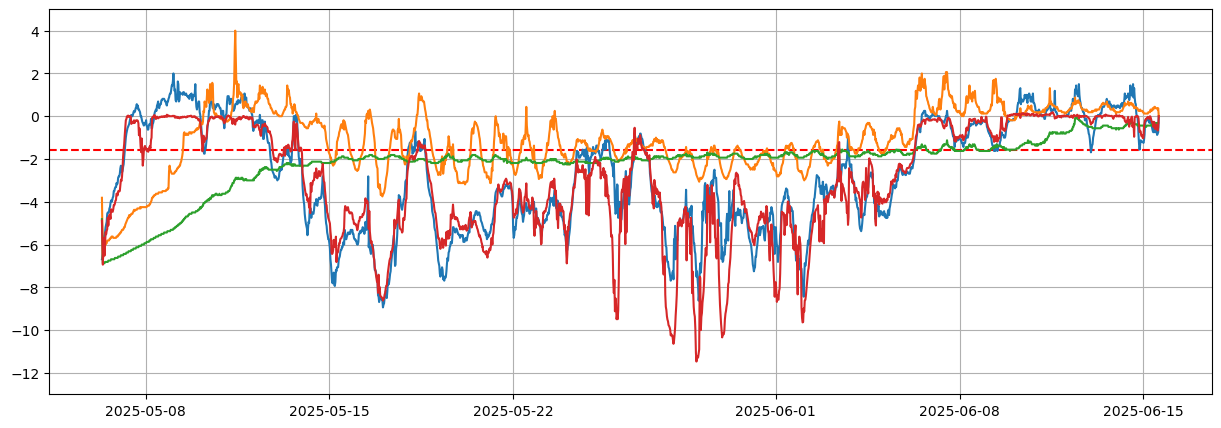

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

ax.axhline(-1.6, ls = '--', c = 'r')
ax.plot(buoy_kvs_10_time, buoy_kvs_10_t1m)   # 1-meter temperature
ax.plot(buoy_kvs_10_time, dataset['temp_snow_ice_raw'][buoy_kvs_10_idx, :])    # Snow-ice interface
ax.plot(buoy_kvs_10_time, dataset['temp_ice_raw'][buoy_kvs_10_idx, :])  # Temp of ice at 30cm depth
ax.plot(buoy_kvs_10_time, dataset['temp_mlx_ir'][buoy_kvs_10_idx, :])   # Snow surface


ax.set_ylim(-13, 5)

ax.grid(True)

### Attempt to show lat/lon for temp times

In [42]:
reference_time_traj = np.datetime64(dataset['time'].units[14:])


buoy_kvs_10_time_traj = reference_time_traj + dataset['time'][2, :].astype('timedelta64[s]')

print(buoy_kvs_10_time_traj)
print(np.where(np.isnat(buoy_kvs_10_time_traj), buoy_kvs_10_time_traj[0], buoy_kvs_10_time_traj).max())
# print(buoy_kvs_10_time)

buoy_kvs_10_time_diff = buoy_kvs_10_time_traj - buoy_kvs_10_time[:3070]
buoy_kvs_10_time_diff = np.where(np.isnat(buoy_kvs_10_time_diff), 0, buoy_kvs_10_time_diff)

# print(buoy_kvs_10_time_diff.max())

['2025-05-05T21:30:37' '2025-05-05T22:00:36' '2025-05-05T22:30:26' ...
 '2025-07-10T08:00:38' '2025-07-10T08:30:27' '2025-07-10T09:00:39']
2025-07-10T09:00:39


### Sort temp and gps into a df

In [22]:
buoy_kvs_10_df = pd.DataFrame({'t1m': buoy_kvs_10_t1m}, index=buoy_kvs_10_time)

buoy_kvs_10_df = buoy_kvs_10_df.resample('60min').mean()


In [23]:

buoy_kvs_10_traj_df = pd.DataFrame({'lat': dataset['lat'][buoy_kvs_10_idx, :], 'lon': dataset['lon'][buoy_kvs_10_idx, :]}, index=buoy_kvs_10_time_traj)

buoy_kvs_10_traj_df = buoy_kvs_10_traj_df.resample('60min').mean()

In [25]:
full_df = pd.merge(buoy_kvs_10_traj_df, buoy_kvs_10_df, left_index=True, right_index=True)
full_df

,lat,lon,t1m
2025-05-06 08:00:00,80.859299,6.093521,-6.68750
2025-05-06 09:00:00,80.861796,6.113147,-6.21875
2025-05-06 10:00:00,80.863974,6.123736,-5.59375
2025-05-06 11:00:00,80.866541,6.126697,-5.31250
2025-05-06 12:00:00,80.869429,6.125589,-5.00000
...,...,...,...
2025-06-15 08:00:00,80.299771,3.384843,-0.62500
2025-06-15 09:00:00,80.297631,3.404734,-0.65625
2025-06-15 10:00:00,80.293719,3.417010,-0.59375
2025-06-15 11:00:00,80.289027,3.418161,-0.71875


### Fancy animation

In [ ]:
def create_animation():
    map_proj = ccrs.NorthPolarStereo(central_longitude=10)
    data_proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize = (10, 6), subplot_kw = {'projection': map_proj})

    ax.set_extent([-1, 25, 79, 82], crs = data_proj)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    gl.bottom_labels = False
    gl.right_labels = False

    cb = ax.scatter([], [], c=[], cmap = cmocean.cm.thermal, transform = data_proj)
    cbar = fig.colorbar(cb, ax = ax, label = 'Temperature [T1M]')

    scatter_plots = []
    points_per_frame = max(1, len(full_df) // 50)

    def animate(frame):
        start_idx = frame * points_per_frame
        end_idx = min(start_idx + points_per_frame, len(full_df))

        if start_idx < len(full_df):
            new_lons = full_df['lon'].iloc[start_idx:end_idx].values
            new_lats = full_df['lat'].iloc[start_idx:end_idx].values
            new_temps = full_df['t1m'].iloc[start_idx:end_idx].values

            new_scatter = ax.scatter(new_lons, new_lats, c = new_temps, cmap = cmocean.cm.thermal, transform = data_proj)

            scatter_plots.append(new_scatter)

        total_points = min(end_idx, len(full_df))
        ax.set_title(f"Frame {frame + 1}")

        return scatter_plots
    
    total_frames = (len(full_df) + points_per_frame - 1) // points_per_frame

    anim = animation.FuncAnimation(fig, animate, frames = total_frames, interval = 100, repeat = True, blit = False)

    return fig, anim

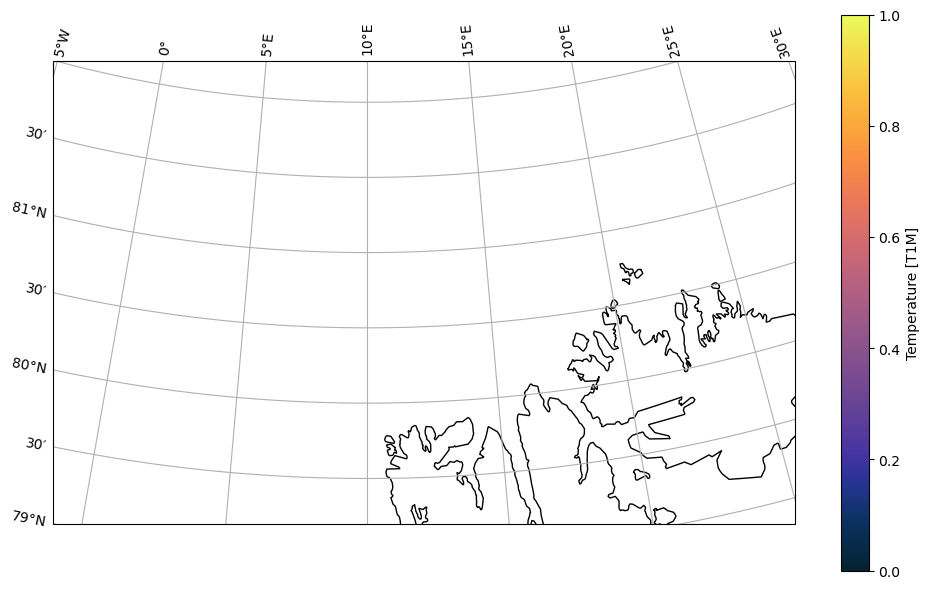

In [94]:
fig, anim = create_animation()
plt.tight_layout()
plt.show()

### Simple figure

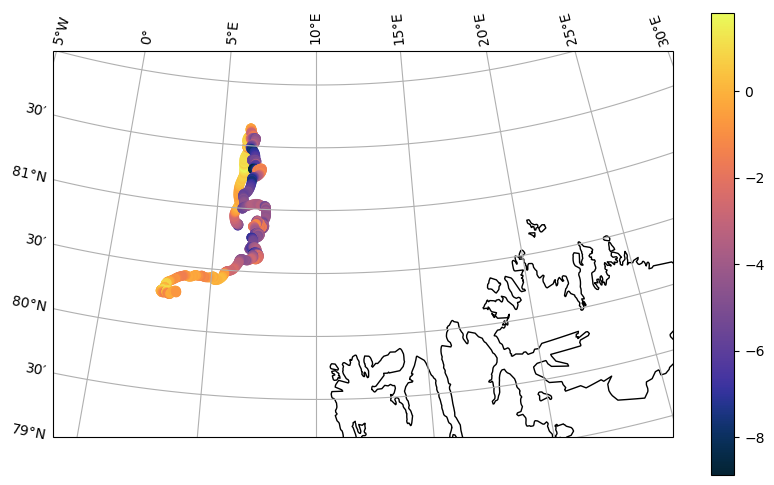

In [64]:
map_proj = ccrs.NorthPolarStereo(central_longitude=10)
data_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), subplot_kw = {'projection': map_proj})

cb = ax.scatter(full_df['lon'], full_df['lat'], c = full_df['t1m'], cmap = cmocean.cm.thermal, transform = data_proj)
ax.set_extent([-1, 25, 79, 82], crs = data_proj)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False

fig.colorbar(cb)

### Copilot example
Copilot is now disabled

Global Attributes:
Conventions: CF-1.10
featureType: trajectory
geospatial_lat_min: 78.0894565
geospatial_lat_max: 81.6920886
geospatial_lon_min: -2.3144882
geospatial_lon_max: 15.9829378
time_coverage_start: 2025-04-27T10:00:36
time_coverage_end: 2025-07-10T09:00:39
creator_name: Jean Rabault
creator_email: jean.rblt@gmail.com
title: SvalMIZ-25: OMB 2025 deployment North East of Svalbard from the KV-Svalbard ship
summary: The SvalMIZ-25 deployment: OMB 2025 KV-Svalbard deployment buoys data. For more information, see https://github.com/jerabaul29/2025_Svalbard_MIZ_KVS_SvalMIZ25 .
creator_institution: Norwegian Meteorological Institute
history: created with trajan.reader.omb from a Rock7 Iridium CSV file of OMB transmissions
version: v1.0
version_date: 2025-09-10

Dimensions:
trajectory: 20
frequencies_waves_imu: 55
obs: 3070
obs_waves_imu: 789
obs_temp: 3145

Variables:
trajectory: ('trajectory',), <class 'str'>
frequencies_waves_imu: ('frequencies_waves_imu',), float64
time: ('trajec

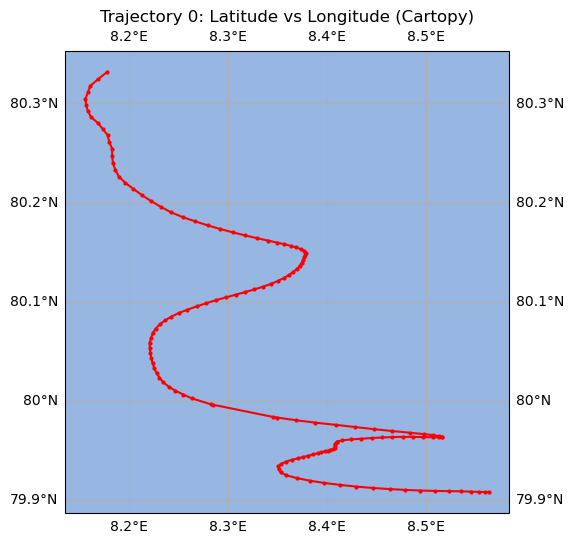

In [6]:


# Print global attributes
print("Global Attributes:")
for attr in dataset.ncattrs():
    print(f"{attr}: {getattr(dataset, attr)}")

# Print dimensions
print("\nDimensions:")
for dim in dataset.dimensions.values():
    print(f"{dim.name}: {len(dim)}")

# Print variables
print("\nVariables:")
for var in dataset.variables.values():
    print(f"{var.name}: {var.dimensions}, {var.dtype}")

# Plot latitude and longitude for the first trajectory using Cartopy
lat = dataset.variables['lat'][0, :]
lon = dataset.variables['lon'][0, :]

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Trajectory 0: Latitude vs Longitude (Cartopy)')
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)
ax.plot(lon, lat, marker='o', linestyle='-', markersize=2, color='red', transform=ccrs.PlateCarree())
plt.show()